# Dynamic Containment

In this notebook, we use the simulations developed in the `modelling_frequency_data` notebook to investigate the state-of-charge of a battery offering three service powers: 2 MW, 5 WM, and 10 MW.

We look at how the state-of-charge responds to changes in frequency over time. We also investigate the optimal initial stored energy for each service. We use the simulations to investigate the uncertainties associated with how long it takes the stored battery energy to reach either zero or maximum capacity. We define this time as the termination time.

In [1]:
# Here we 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from dynamic_containment import utils

plt.rcParams['text.usetex'] = False

The goal in this notebook is to investigate how dynamic containment can be used to complement a power grid when frequency deviates from 50 Hz in the grid.

As a starting piont, assuming only random Gaussian noise, and following the discussion in the `modelling_frequency_data` notebook, we can calculate the expected rate of change of the energy for all three service powers.

First, we set our parameters

In [2]:
service_powers = np.array([2, 5, 10])

max_cap = 4 # The maximum capacity (MWh)

max_charge_rate = 4.0 # The maximum charge rate (MW)
max_discharge_rate = 5.0 # The maximum discharge rate (MW)

charge_efficiency = 0.9

max_percent = max_charge_rate / service_powers
min_percent = max_discharge_rate / service_powers

alpha = (1 - 0.05)/(0.5 - 0.2) # This is the slope of the response curve between the elbow and full response
ccharge = 1 - 0.5 * alpha # This is the constant for the curve in the discharge state
# Note we only use this part of the response curve to estimate the maxium and minimum frequencies that the batter can respond to.
# The full response curve is used to model charge changes. As shown in the first plot of `modelling_frequency_data` 
    
delta_freq_max = (max_percent - ccharge) / alpha
delta_freq_min = -(min_percent - ccharge) / alpha

To calculate the level of white noise, we can use the data for our variance. Note, we are using the original uncut data to cteate our simulations. In this notebook we do not cut the data, since missing data does not affect the covariance estimate, but cutting and moving data around will likely affect it.

In [3]:
freq_table = utils.read_and_clean()

## The expectation value of the stored energy

We showed in the `modelling_frequency_data` notebook that the mean value of the frequency in our test data is consistent with 50 Hz.

We also demonstrated that assuming only Gaussian noise does a good job when predicting the expectation value of the energy of the battery when we ignore the limits of maximum capacity and an empty battery. We start with these assumptions, since Gaussian noise requires only an estimate of the variance, and so is less impacted by uncertainty. The expected energy at time $t$ is then given by the relation

\begin{equation}
\left<E(t)\right>=E_0+t\int^{\infty}_{-\infty} P_{\delta f}\left(\delta f\right|\sigma_{\delta f}^2)y(\delta f)\,\mathrm{d}\delta f \label{eq1}\tag{1}
\end{equation}

where $\delta f=f-50$ Hz and $P_{\delta f}$ is a normal distribution, with zero mean and variance $\sigma_{\delta f}^2$. $y(\delta f)$ is the piecewise linear function describing the response of the battery charge to $\delta f$, where we include the battery specifications - this is shown in the first plot in the `modelling_frequency_data` notebook. The energy at $t=0$, $E_0$, is the initial energy stored in the battery.

Here, we have made the assumption that $\delta f$ is unbound. Let's look at the validity this assumption


In [4]:
print(f"For the uncut data, the standard deviation of the frequency is {np.round(freq_table.delta_freq.std(), 3)} Hz")

For the uncut data, the standard deviation of the frequency is 0.06 Hz


In [5]:
print("Respectively for the 2 MW, 5 MW and 10 MW service powers\n")
print("\tThe maximum charge rates are at %s percent, %s percent, and %s percent" % tuple(100*max_percent))
print(f"\tThese are when delta freq are {np.round(delta_freq_max, 2)} Hz\n")
print(f"\tThe maximum discharge rates are at %s percent, %s percent, and %s percent" % tuple(100*min_percent))
print(f"\tThese are when delta freq are {np.round(delta_freq_min, 2)} Hz")

Respectively for the 2 MW, 5 MW and 10 MW service powers

	The maximum charge rates are at 200.0 percent, 80.0 percent, and 40.0 percent
	These are when delta freq are [0.82 0.44 0.31] Hz

	The maximum discharge rates are at 250.0 percent, 100.0 percent, and 50.0 percent
	These are when delta freq are [-0.97 -0.5  -0.34] Hz


In [6]:
print(f"For the 10 MW case, where the maximum and minimum charge rates are at the lowest frequencies, we expect these charge rates to be exceeded, on average, for 1 second every {np.round((1.0/(1.0 - utils.probability_tails(0.31/0.06, 0.34/0.06)))/86400, 2)} days") 

For the 10 MW case, where the maximum and minimum charge rates are at the lowest frequencies, we expect these charge rates to be exceeded, on average, for 1 second every 91.54 days


The fact that some of the charge and discharge rates are greater than 100 % is an indication that the maximum charge and discharge rates are greater than the service power, and so these should be capped at 100 %.

For those cases where the rates are lower than 100%, the battery specifications cannot achieve the contract requirements, and so the battery should not be used. For the 5 MW service power, where the maximum discharge rate is 100%, but the charge rate is 80%, the battery can fill the contract of a `low` flavour. The 10 MW service power cannot be fulfilled by the battery.

It is clear the magnitude of the minimum and maximum values of the frequencies in all cases is > 5 $\sigma_{\delta f}$, and so, when calculating the expectation of the rate of change in energy, it is reasonable to assume that the integral is unbound. However, it should be noted that, given the length of time that the battery runs for, these frequencies may occur. Assuming normal distributed noise-only, the integral above gives us the rate of change of energy

\begin{equation}
\frac{\mathrm{d}E}{\mathrm{d}t}=\int^{\infty}_{-\infty} P_{\delta f}\left(\delta f\right|\sigma_{\delta f}^2)y(\delta f)\,\mathrm{d}\delta f \label{eq2}\tag{2}
\end{equation}

In [7]:
# This calculates the above integral

dcdt = np.array([
    utils.calc_gaussian_slope(freq_table.delta_freq.std(), sp)
    for sp in service_powers
])

This provides our estimate of the rate of change of stored energy when we are not impacted by specifications for the 2 MW, 5 MW and 10 MW services respectively as

In [8]:
print(f"The average rate of change of energy is: {dcdt * 3600} MW")

The average rate of change of energy is: [-0.00116609 -0.00291523 -0.00583049] MW


Assuming we start with a full battery, the expectation of the stored energy is shown below

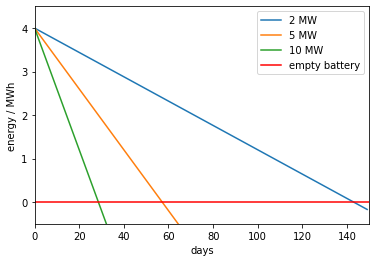

In [9]:
days = np.arange(150)
plt.plot(days, max_cap + days * (dcdt[0]*(3600.0 * 24.0)), label="2 MW")
plt.plot(days, max_cap + days * (dcdt[1]*(3600.0 * 24.0)), label="5 MW")
plt.plot(days, max_cap + days * (dcdt[2]*(3600.0 * 24.0)), label="10 MW")
plt.axhline(0, color='red', label="empty battery")
plt.ylabel("energy / MWh")
plt.xlabel("days")
plt.xlim([0, 150])
plt.ylim([-0.5, max_cap + 0.5])
plt.legend()


## Including stochasticity

Now we follow the more realistic approach and generate a suite of simulations using the two-point correlation of the frequency data, which capatures temporal correlations.

Note that we generate the simulations as discussed in detail in the `modelling_frequency_data` notebook, assuming normal distributed frequencies with the standard deviation given above: 0.06 Hz.

We start by calculating the covariance of $\delta f$ as a function of temporal separation

In [10]:
# Simulate in blocks of this number of seconds (This is selected to keep bias in the noise below 5%)
block_length = 36000

# Here, we calculate the covariance of the data as a function of temporal separation
real_space_cov = utils.temporal_covariance(freq_table, max_sep=block_length, step=60)

  0%|          | 0/600 [00:00<?, ?it/s]

Next, we set the number of realisations and the time steps at which to sample the data. We are currently using a fairly large time step to speed things up, but we verified that sampling at this scale should not cause significant increases in the uncertainty estimates due to the level of correlation at smaller scales.

In [11]:
# This is the number of realisations.
nreals = 500
# We sample the time (this may affect the noise properties)
time_step = 600
# Number of days to simulate
num_days = 400

Now we create independent simulations for the three service powers. These simulate how the energy stored in the battery changes over time, without considering the capacity of the battery. These will then be used to see where the different realisations reach their termination dates.

Note, we output results for the `high`, `low` and `both` scenarios. This can take a while to run with a few hundred simulations, and this is the main reason for the approximations used. 

In [12]:
summaries, reals = utils.simulations_for_anaylsis(
    real_space_cov,
    service_powers,
    nreals,
    time_step,
    num_days=num_days,
    block_length=block_length,
    max_discharge_rate=max_discharge_rate,
    max_charge_rate=max_charge_rate,
    charge_efficiency=charge_efficiency
)

creating simulation for service power 2
creating simulation for service power 5
creating simulation for service power 10


We can select a date to look at the distribution of energies over the realisations. 

In [13]:
day = 10 # We will look at the start of day 10
sp = 2 # the service power to look at

keep_energy = int(day*86400/time_step)
samp_energy = []

for s in reals[sp]:
    
    samp_energy.append(float(reals[sp][s].iloc[keep_energy].culm_charge))

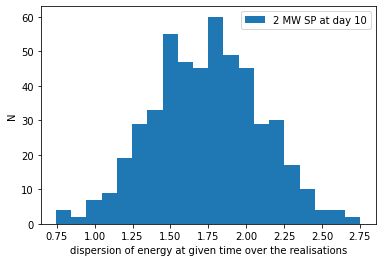

In [14]:
hist = plt.hist(0.5*max_cap + np.array(samp_energy), bins=20, label=f"{sp} MW SP at day {day}")
plt.xlabel("dispersion of energy at given time over the realisations")
plt.ylabel('N')
plt.legend()

We will now find the intial energy that provides the longest expected termination date. We first do this for a service power of 10 MW as a demonstration, before doing it for all three service powers.

We create a simple optimsation that uses polyfit to fit a curve to the mean termination date as a function of the intial stored energy. A polynomial was fitted to avoid accidentally fitting to a peak due to noise. Smoothing was found to be less robust due to the same realisations being used for each test, and hence correlated noise. This could be improved in the future by using more realisations and different realisations for each test.

In [15]:
service_power = 5
num_energy_steps = 21
min_energy_lim = 2 # This is the lower bound of the optimisation
max_energy_lim = 4 # This is the upper bound of the optimisation
poly_deg = 6 # Six was selected for the degree of polynomial to provide a good fit for all three service powers

In [16]:
E_best, d_mean, E_arr = utils.find_E0_for_max_time(
    reals,
    service_power,
    max_cap=max_cap,
    min_energy_lim=min_energy_lim,
    max_energy_lim=max_energy_lim,
    num_energy_steps=num_energy_steps,
    poly_deg=poly_deg
)

In [17]:
res = np.polyfit(E_arr, d_mean, deg=poly_deg)

Text(0, 0.5, 'days berfore terminating')

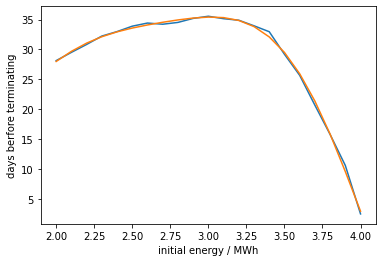

In [18]:
plt.plot(E_arr, np.array(d_mean) * time_step / (3600.0 * 24.0))
plt.plot(E_arr, np.poly1d(res)(E_arr) * time_step / (3600.0 * 24.0))
plt.xlabel("initial energy / MWh")
plt.ylabel('days berfore terminating')

The best starting point is then

In [19]:
print(f"E_0 = {E_best} MWh")

E_0 = 3.0 MWh


This gives the expected best date

In [20]:
dates = utils.max_date_func(E_best, reals, service_power, max_cap)*time_step /(3600.0 * 24.0)

print(f"{np.round(np.mean(dates), 2)} days")

35.55 days


Let's look at a histogram of the termination dates over the realisations

Text(0, 0.5, 'N')

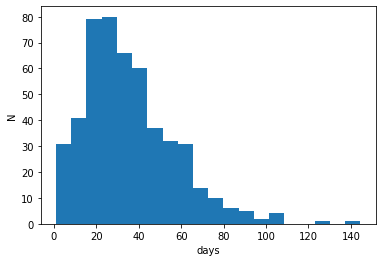

In [21]:
hist = plt.hist(dates, bins=20)
plt.xlabel("days")
plt.ylabel("N")

From this, we can see that there is a large dispersion in the simulations.

Lets run this for all three service powers and look at the 95% confidence intervals, running with the three flavours - `both`, `high` and `low`

In [22]:
results_both = utils.service_power_loop(
    reals,
    service_powers,
    max_cap=max_cap,
    time_step=time_step,
    min_energy_lim=min_energy_lim,
    max_energy_lim=max_energy_lim,
    num_energy_steps=num_energy_steps,
    poly_deg=poly_deg,
    verbose=False,
)

In [23]:
results_low = utils.service_power_loop(
    reals,
    service_powers,
    max_cap=max_cap,
    time_step=time_step,
    min_energy_lim=min_energy_lim,
    max_energy_lim=max_energy_lim,
    num_energy_steps=num_energy_steps,
    service='low',
    poly_deg=poly_deg,
    verbose=False
)

In [24]:
results_high = utils.service_power_loop(
    reals,
    service_powers,
    max_cap=max_cap,
    time_step=time_step,
    min_energy_lim=min_energy_lim,
    max_energy_lim=max_energy_lim,
    num_energy_steps=num_energy_steps,
    service='high',
    poly_deg=poly_deg,
    verbose=False
)

In [25]:
pd.concat([results_both["table"], results_high["table"], results_low["table"]])

,Initial Energy / MWh,Expected Termination Date,95.0% Confidence Interval
2MW - both,3.4,115.64 days,13.42 - 221.53 days
5MW - both,3.0,35.55 days,4.26 - 87.39 days
10MW - both,2.7,12.51 days,1.41 - 42.88 days
2MW - high,0.0,15.86 days,14.13 - 17.75 days
5MW - high,0.0,6.4 days,5.28 - 7.62 days
10MW - high,0.0,3.2 days,2.42 - 3.97 days
2MW - low,4.0,14.41 days,12.72 - 16.16 days
5MW - low,4.0,5.75 days,4.69 - 6.79 days
10MW - low,4.0,2.86 days,2.17 - 3.57 days


One interesting result here is that, when we take the initial energy into account, the expected termination times are less than those provided by the rates of change of stored energy calculated using equation (2). Equations (1) and (2) calculate the expectation of the energy of the battery at a given time step. However, the mean of the distribution of termination dates is not the same as the point at which the expectation of the charge crosses the empty charge limit.

We have already stated that the 10MW service cannot be achieved given the battery specifications. Also, the battery can only provide the `low` flavour for the 5MW service, due to the limitation of the maximum charge rate.

We also see that the confidence intervals are very large for the `both` service.

Finally let's look at how this behaves if we change the maximum capacity of the battery.

In [26]:
max_cap_arr = np.linspace(2, 6, num=11)

service_power = 5
num_energy_steps = 9

fit_conf = 0.95

results = utils.loop_max_cap(
    reals,
    max_cap_arr,
    service_power,
    time_step,
    num_energy_steps,
    service="both",
    poly_deg=poly_deg
)

Service power = 5


Text(0.5, 0, 'max capacity / MWh')

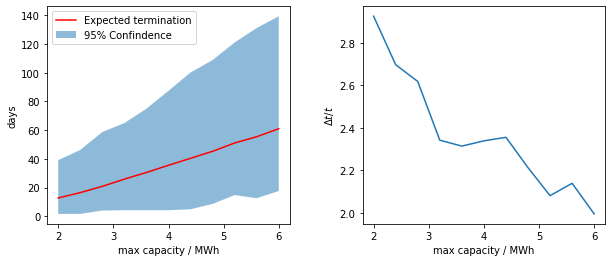

In [27]:
print(f"Service power = {service_power}")

fig = plt.figure(figsize=(10,4))
fig.subplots_adjust(hspace=0.4, wspace=0.3)
ax = fig.add_subplot(1, 2, 1)

plt.plot(max_cap_arr, results["exp_dates"], color='red', label="Expected termination")
plt.fill_between(
    max_cap_arr,
    results["upper_limits"],
    results["lower_limits"],
    alpha=0.5,
    label=f"{int(np.round(100*fit_conf))}% Confindence"
)
plt.ylabel("days")
plt.xlabel("max capacity / MWh")
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(max_cap_arr, (results["upper_limits"]-results["lower_limits"])/results["exp_dates"])
plt.ylabel("$\Delta t/t$")
plt.xlabel("max capacity / MWh")

So we see that, as the maximum capacity of the battery increases, so does the uncertainty in the termination time. This is expected since, as the lifetime of the battery increases, we are integrating over more frequency samples, each of which has an associated uncertainty. However, we also see that the fractional uncertainty of the time decreases. As shown below, this is also the case for running the `low` service.

In [28]:
max_cap_arr = np.linspace(2, 20, num=10)

service_power = 5
num_energy_steps = 9

fit_conf = 0.95

results = utils.loop_max_cap(
    reals,
    max_cap_arr,
    service_power,
    time_step,
    num_energy_steps,
    service="low",
    poly_deg=poly_deg
)

Service power = 5


Text(0.5, 0, 'max capacity / MWh')

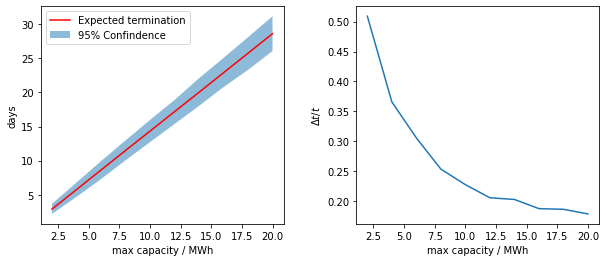

In [29]:
print(f"Service power = {service_power}")

fig = plt.figure(figsize=(10,4))
fig.subplots_adjust(hspace=0.4, wspace=0.3)
ax = fig.add_subplot(1, 2, 1)

plt.plot(max_cap_arr, results["exp_dates"], color='red', label="Expected termination")
plt.fill_between(
    max_cap_arr,
    results["upper_limits"],
    results["lower_limits"],
    alpha=0.5,
    label=f"{int(np.round(100*fit_conf))}% Confindence"
)
plt.ylabel("days")
plt.xlabel("max capacity / MWh")
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(max_cap_arr, (results["upper_limits"]-results["lower_limits"])/results["exp_dates"])
plt.ylabel("$\Delta t/t$")
plt.xlabel("max capacity / MWh")

Due to the symmetry in response when charging and discharging, this behaviour is also seen for the `high` flavour.

## Conclusions

From the results above, we can recommend the battery be used for the 2MW service power, with the `both` flavour and with an initial stored energy of 3.4 MWh, given this is expected to provide the longest service within the 95% confidence interval. However, it should be noted that the confidence interval for this service is large, and if one requires an accurate knowledge of the running time of the battery, running two batteries, one in `low` and one in `high` would provide the service, with a much more accurate estimate of the running time in each case, albeit for a shorter expected termination time.

For the 5MW service power, we are limited by the contracted power to use the battery in the `low` flaovour, due to limimtations on the maximum discharge rate.

The 10MW service cannot be provided by the battery.

If we increases the maximum capacity of the battery, we see that we also increase the absolute uncertainty in the running time of the battery in any flavour. However, the fractional uncertainty decreases. Therefore, if we are concerned with accurately planning for maintainaince costs associated with changing batteries, we may wish to consider a higher battery capacity.